<a href="https://colab.research.google.com/github/peyyalapraveen7-byte/RECOMMENDATION-SYSTEM/blob/main/recomendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 Initializing Movie Recommendation System...
🎬 MOVIE RECOMMENDATION SYSTEM DEMO 🎬
Loading data...
Generating synthetic movie rating data...
Generated 47589 ratings for 1000 users
and 500 movies

DATA ANALYSIS
Total ratings: 47,589
Unique users: 1,000
Unique movies: 500
Rating range: 1.0 - 5.0
Average rating: 3.45
Sparsity: 90.48%


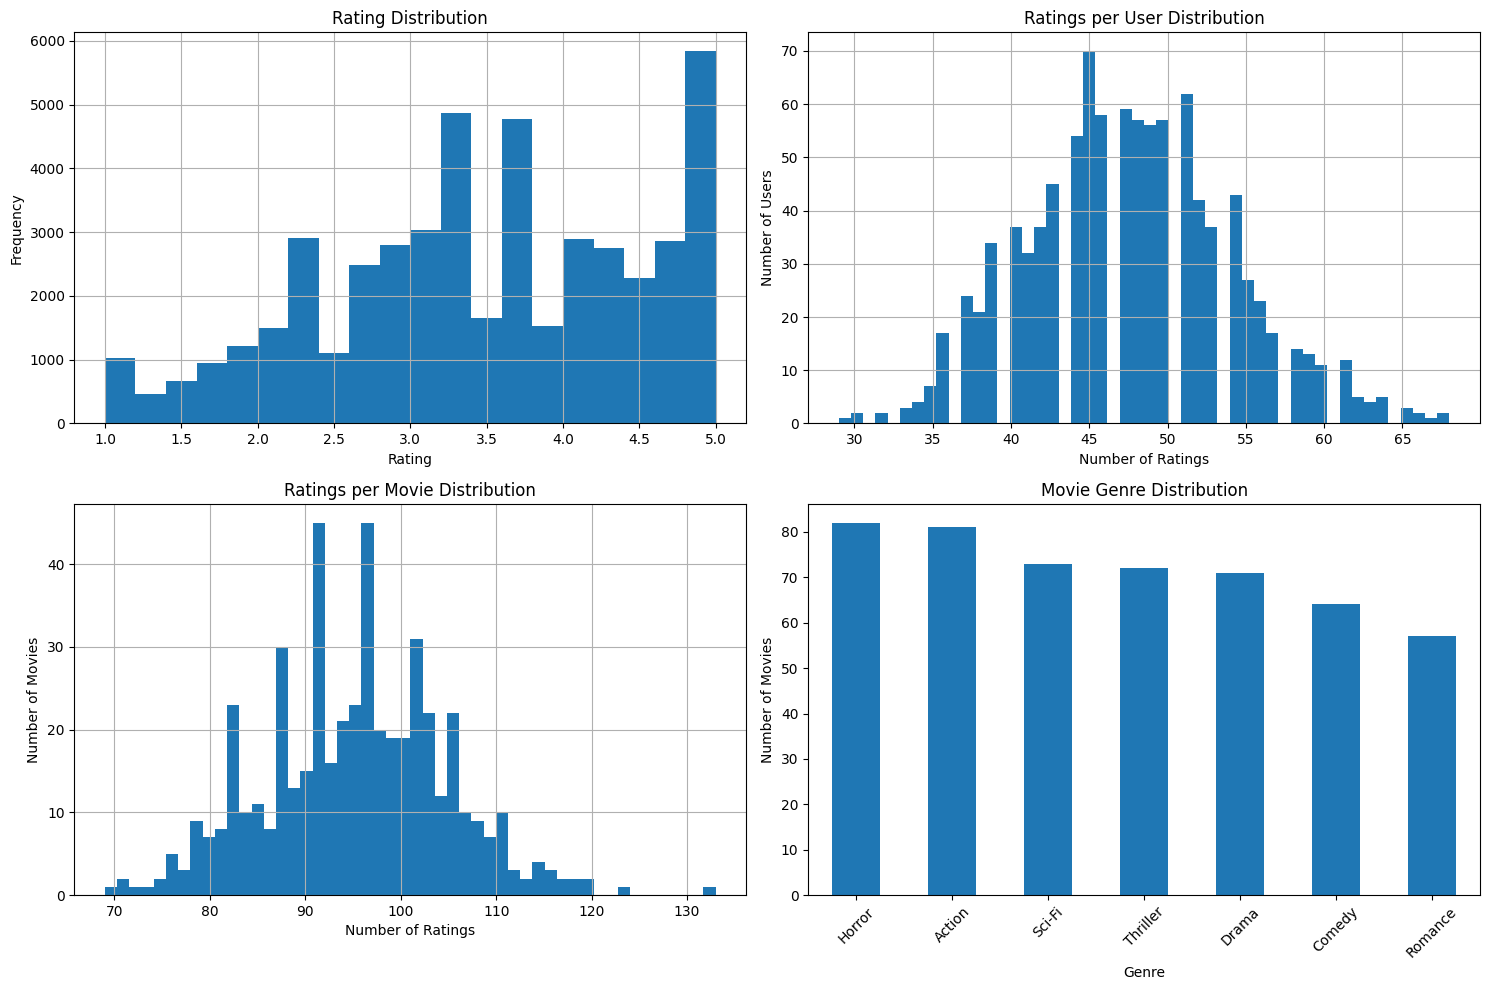


TRAINING RECOMMENDATION MODELS
Data prepared: 1000 users, 500 items
Computing user similarity matrix...
User similarity matrix computed: (1000, 1000)
Computing item similarity matrix...
Item similarity matrix computed: (500, 500)
Matrix Factorization data prepared: (1000, 500)
Training SVD model...
SVD model trained with 30 factors
Training NMF model...
NMF model trained with 30 factors

All models trained successfully!

Showing user 783's rating history:
  Thriller Movie 53 (Thriller) - Rating: 5.0
  Romance Movie 14 (Romance) - Rating: 5.0
  Comedy Movie 91 (Comedy) - Rating: 5.0
  Sci-Fi Movie 475 (Sci-Fi) - Rating: 5.0
  Thriller Movie 399 (Thriller) - Rating: 5.0
  Romance Movie 106 (Romance) - Rating: 5.0
  Horror Movie 38 (Horror) - Rating: 4.9
  Drama Movie 406 (Drama) - Rating: 4.8
  Romance Movie 107 (Romance) - Rating: 4.6
  Comedy Movie 363 (Comedy) - Rating: 4.5

RECOMMENDATIONS FOR USER 783

1. USER-BASED COLLABORATIVE FILTERING:
 1. Horror Movie 402 (Horror) - Predicted

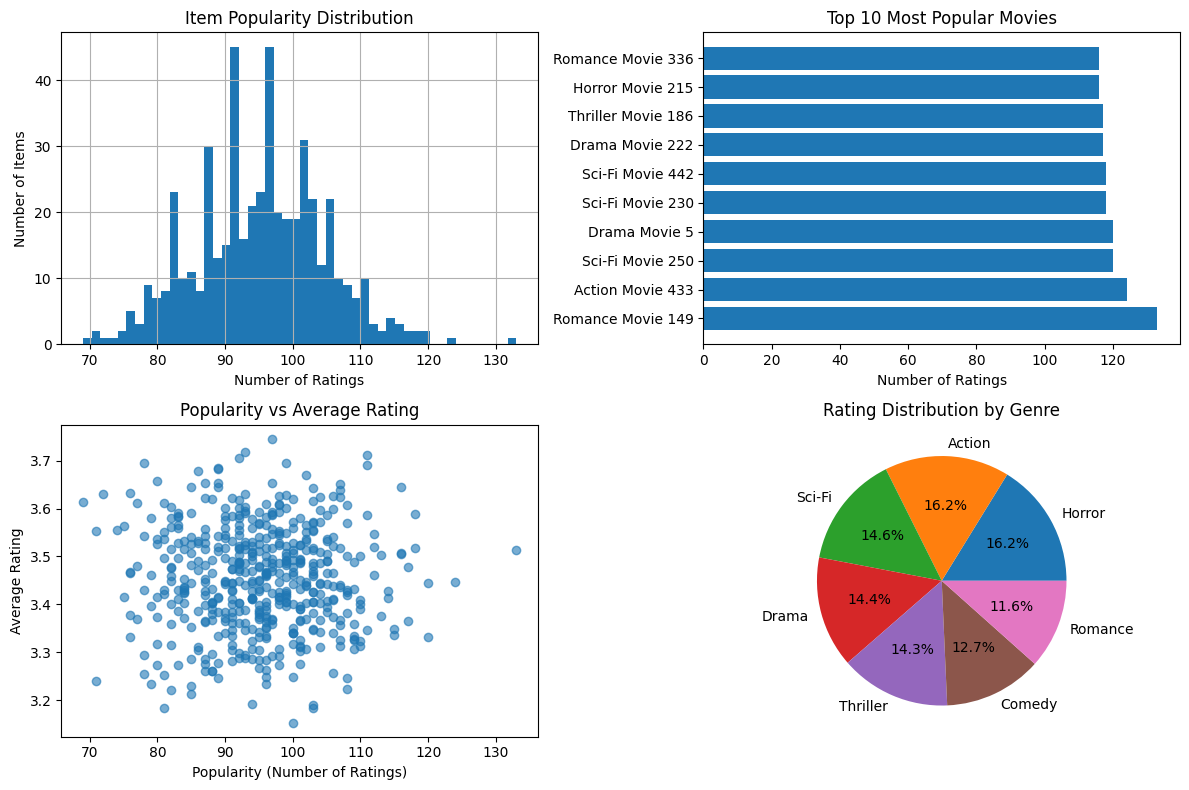


RECOMMENDATIONS FOR USER 783

1. USER-BASED COLLABORATIVE FILTERING:
 1. Horror Movie 402 (Horror) - Predicted Rating: 3.98
 2. Action Movie 378 (Action) - Predicted Rating: 3.91
 3. Sci-Fi Movie 233 (Sci-Fi) - Predicted Rating: 3.84
 4. Action Movie 309 (Action) - Predicted Rating: 3.83
 5. Thriller Movie 251 (Thriller) - Predicted Rating: 3.79
 6. Horror Movie 481 (Horror) - Predicted Rating: 3.79
 7. Drama Movie 268 (Drama) - Predicted Rating: 3.78
 8. Sci-Fi Movie 211 (Sci-Fi) - Predicted Rating: 3.78

2. ITEM-BASED COLLABORATIVE FILTERING:
 1. Horror Movie 46 (Horror) - Predicted Rating: 4.12
 2. Drama Movie 354 (Drama) - Predicted Rating: 3.93
 3. Romance Movie 30 (Romance) - Predicted Rating: 3.92
 4. Horror Movie 191 (Horror) - Predicted Rating: 3.89
 5. Drama Movie 194 (Drama) - Predicted Rating: 3.86
 6. Sci-Fi Movie 321 (Sci-Fi) - Predicted Rating: 3.85
 7. Sci-Fi Movie 101 (Sci-Fi) - Predicted Rating: 3.82
 8. Romance Movie 190 (Romance) - Predicted Rating: 3.82

3. SVD MA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

class RecommendationConfig:
    """Configuration class for recommendation system"""
    def __init__(self):
        self.N_FACTORS = 50  # Number of latent factors for matrix factorization
        self.N_RECOMMENDATIONS = 10  # Number of recommendations to return
        self.MIN_INTERACTIONS = 5  # Minimum interactions per user/item
        self.TEST_SIZE = 0.2
        self.RANDOM_STATE = 42
        self.SIMILARITY_THRESHOLD = 0.1
        self.MAX_ITERATIONS = 100
        self.LEARNING_RATE = 0.01
        self.REGULARIZATION = 0.01

class DataGenerator:
    """Generate sample movie rating data for demonstration"""

    def __init__(self, n_users=1000, n_items=500, n_ratings=50000):
        self.n_users = n_users
        self.n_items = n_items
        self.n_ratings = n_ratings

    def generate_movie_data(self):
        """Generate synthetic movie rating data"""
        np.random.seed(42)

        # Generate movie titles
        genres = ['Action', 'Comedy', 'Drama', 'Horror', 'Romance', 'Sci-Fi', 'Thriller']
        movie_names = [f"{np.random.choice(genres)} Movie {i+1}" for i in range(self.n_items)]

        # Generate users and ratings with some realistic patterns
        user_ids = np.random.randint(1, self.n_users + 1, self.n_ratings)
        movie_ids = np.random.randint(1, self.n_items + 1, self.n_ratings)

        # Generate ratings with some user preferences
        ratings = []
        for user_id, movie_id in zip(user_ids, movie_ids):
            # Add some user bias and movie popularity bias
            user_bias = np.random.normal(0, 0.5)
            movie_bias = np.random.normal(0, 0.3)
            base_rating = 3.5 + user_bias + movie_bias
            rating = np.clip(np.random.normal(base_rating, 1), 1, 5)
            ratings.append(round(rating, 1))

        # Create ratings dataframe
        ratings_df = pd.DataFrame({
            'user_id': user_ids,
            'movie_id': movie_ids,
            'rating': ratings
        })

        # Remove duplicates (keep first occurrence)
        ratings_df = ratings_df.drop_duplicates(subset=['user_id', 'movie_id'])

        # Create movies dataframe
        movies_df = pd.DataFrame({
            'movie_id': range(1, self.n_items + 1),
            'title': movie_names,
            'genre': [name.split()[0] for name in movie_names]
        })

        return ratings_df, movies_df

    def load_sample_data(self):
        """Load or generate sample data"""
        print("Generating synthetic movie rating data...")
        ratings_df, movies_df = self.generate_movie_data()

        print(f"Generated {len(ratings_df)} ratings for {ratings_df['user_id'].nunique()} users")
        print(f"and {ratings_df['movie_id'].nunique()} movies")

        return ratings_df, movies_df

class CollaborativeFiltering:
    """User-based and Item-based Collaborative Filtering"""

    def __init__(self, config: RecommendationConfig):
        self.config = config
        self.user_item_matrix = None
        self.user_similarity = None
        self.item_similarity = None
        self.users_df = None
        self.items_df = None

    def prepare_data(self, ratings_df, movies_df):
        """Prepare data for collaborative filtering"""
        # Filter users and items with minimum interactions
        user_counts = ratings_df['user_id'].value_counts()
        item_counts = ratings_df['movie_id'].value_counts()

        valid_users = user_counts[user_counts >= self.config.MIN_INTERACTIONS].index
        valid_items = item_counts[item_counts >= self.config.MIN_INTERACTIONS].index

        filtered_ratings = ratings_df[
            (ratings_df['user_id'].isin(valid_users)) &
            (ratings_df['movie_id'].isin(valid_items))
        ].copy()

        # Create user-item matrix
        self.user_item_matrix = filtered_ratings.pivot(
            index='user_id',
            columns='movie_id',
            values='rating'
        ).fillna(0)

        self.movies_df = movies_df

        print(f"Data prepared: {self.user_item_matrix.shape[0]} users, {self.user_item_matrix.shape[1]} items")
        return filtered_ratings

    def compute_user_similarity(self):
        """Compute user-user similarity matrix"""
        print("Computing user similarity matrix...")
        # Convert to sparse matrix for efficiency
        sparse_matrix = csr_matrix(self.user_item_matrix.values)

        # Compute cosine similarity
        self.user_similarity = cosine_similarity(sparse_matrix)

        # Convert to DataFrame for easier indexing
        self.user_similarity = pd.DataFrame(
            self.user_similarity,
            index=self.user_item_matrix.index,
            columns=self.user_item_matrix.index
        )

        print(f"User similarity matrix computed: {self.user_similarity.shape}")

    def compute_item_similarity(self):
        """Compute item-item similarity matrix"""
        print("Computing item similarity matrix...")
        # Transpose matrix for item-item similarity
        sparse_matrix = csr_matrix(self.user_item_matrix.T.values)

        # Compute cosine similarity
        self.item_similarity = cosine_similarity(sparse_matrix)

        # Convert to DataFrame
        self.item_similarity = pd.DataFrame(
            self.item_similarity,
            index=self.user_item_matrix.columns,
            columns=self.user_item_matrix.columns
        )

        print(f"Item similarity matrix computed: {self.item_similarity.shape}")

    def predict_rating_user_based(self, user_id, movie_id, k=50):
        """Predict rating using user-based collaborative filtering"""
        if user_id not in self.user_similarity.index or movie_id not in self.user_item_matrix.columns:
            return self.user_item_matrix.values.mean()

        # Get user similarities
        user_similarities = self.user_similarity.loc[user_id]

        # Get users who rated this movie
        movie_ratings = self.user_item_matrix[movie_id]
        rated_users = movie_ratings[movie_ratings > 0]

        if len(rated_users) == 0:
            return self.user_item_matrix.values.mean()

        # Get similarities with users who rated this movie
        similarities = user_similarities[rated_users.index]

        # Filter by similarity threshold and get top-k
        similarities = similarities[similarities > self.config.SIMILARITY_THRESHOLD]
        similarities = similarities.nlargest(k)

        if len(similarities) == 0:
            return self.user_item_matrix.values.mean()

        # Weighted average
        numerator = (similarities * rated_users[similarities.index]).sum()
        denominator = similarities.sum()

        return numerator / denominator if denominator > 0 else self.user_item_matrix.values.mean()

    def predict_rating_item_based(self, user_id, movie_id, k=50):
        """Predict rating using item-based collaborative filtering"""
        if user_id not in self.user_item_matrix.index or movie_id not in self.item_similarity.index:
            return self.user_item_matrix.values.mean()

        # Get user's ratings
        user_ratings = self.user_item_matrix.loc[user_id]
        rated_items = user_ratings[user_ratings > 0]

        if len(rated_items) == 0:
            return self.user_item_matrix.values.mean()

        # Get item similarities
        item_similarities = self.item_similarity.loc[movie_id]

        # Get similarities with items rated by this user
        similarities = item_similarities[rated_items.index]

        # Filter by similarity threshold and get top-k
        similarities = similarities[similarities > self.config.SIMILARITY_THRESHOLD]
        similarities = similarities.nlargest(k)

        if len(similarities) == 0:
            return self.user_item_matrix.values.mean()

        # Weighted average
        numerator = (similarities * rated_items[similarities.index]).sum()
        denominator = similarities.sum()

        return numerator / denominator if denominator > 0 else self.user_item_matrix.values.mean()

    def recommend_user_based(self, user_id, n_recommendations=None):
        """Generate user-based recommendations"""
        n_recommendations = n_recommendations or self.config.N_RECOMMENDATIONS

        if user_id not in self.user_item_matrix.index:
            return []

        # Get movies not rated by user
        user_ratings = self.user_item_matrix.loc[user_id]
        unrated_movies = user_ratings[user_ratings == 0].index

        # Predict ratings for unrated movies
        predictions = []
        for movie_id in unrated_movies:
            pred_rating = self.predict_rating_user_based(user_id, movie_id)
            predictions.append((movie_id, pred_rating))

        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)

        recommendations = []
        for movie_id, rating in predictions[:n_recommendations]:
            movie_info = self.movies_df[self.movies_df['movie_id'] == movie_id].iloc[0]
            recommendations.append({
                'movie_id': movie_id,
                'title': movie_info['title'],
                'genre': movie_info['genre'],
                'predicted_rating': round(rating, 2)
            })

        return recommendations

    def recommend_item_based(self, user_id, n_recommendations=None):
        """Generate item-based recommendations"""
        n_recommendations = n_recommendations or self.config.N_RECOMMENDATIONS

        if user_id not in self.user_item_matrix.index:
            return []

        # Get movies not rated by user
        user_ratings = self.user_item_matrix.loc[user_id]
        unrated_movies = user_ratings[user_ratings == 0].index

        # Predict ratings for unrated movies
        predictions = []
        for movie_id in unrated_movies:
            pred_rating = self.predict_rating_item_based(user_id, movie_id)
            predictions.append((movie_id, pred_rating))

        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)

        recommendations = []
        for movie_id, rating in predictions[:n_recommendations]:
            movie_info = self.movies_df[self.movies_df['movie_id'] == movie_id].iloc[0]
            recommendations.append({
                'movie_id': movie_id,
                'title': movie_info['title'],
                'genre': movie_info['genre'],
                'predicted_rating': round(rating, 2)
            })

        return recommendations

class MatrixFactorization:
    """Matrix Factorization using SVD and NMF"""

    def __init__(self, config: RecommendationConfig):
        self.config = config
        self.svd_model = None
        self.nmf_model = None
        self.user_item_matrix = None
        self.movies_df = None
        self.user_mapping = None
        self.item_mapping = None

    def prepare_data(self, ratings_df, movies_df):
        """Prepare data for matrix factorization"""
        # Filter users and items with minimum interactions
        user_counts = ratings_df['user_id'].value_counts()
        item_counts = ratings_df['movie_id'].value_counts()

        valid_users = user_counts[user_counts >= self.config.MIN_INTERACTIONS].index
        valid_items = item_counts[item_counts >= self.config.MIN_INTERACTIONS].index

        filtered_ratings = ratings_df[
            (ratings_df['user_id'].isin(valid_users)) &
            (ratings_df['movie_id'].isin(valid_items))
        ].copy()

        # Create user-item matrix
        self.user_item_matrix = filtered_ratings.pivot(
            index='user_id',
            columns='movie_id',
            values='rating'
        ).fillna(0)

        self.movies_df = movies_df

        # Create mappings for matrix indices
        self.user_mapping = {user: idx for idx, user in enumerate(self.user_item_matrix.index)}
        self.item_mapping = {item: idx for idx, item in enumerate(self.user_item_matrix.columns)}

        print(f"Matrix Factorization data prepared: {self.user_item_matrix.shape}")
        return filtered_ratings

    def train_svd(self):
        """Train SVD model"""
        print("Training SVD model...")
        self.svd_model = TruncatedSVD(
            n_components=self.config.N_FACTORS,
            random_state=self.config.RANDOM_STATE
        )

        # Fit SVD on user-item matrix
        self.svd_model.fit(self.user_item_matrix)

        # Get user and item factors
        self.user_factors = self.svd_model.transform(self.user_item_matrix)
        self.item_factors = self.svd_model.components_.T

        print(f"SVD model trained with {self.config.N_FACTORS} factors")

    def train_nmf(self):
        """Train NMF model"""
        print("Training NMF model...")
        self.nmf_model = NMF(
            n_components=self.config.N_FACTORS,
            random_state=self.config.RANDOM_STATE,
            max_iter=self.config.MAX_ITERATIONS
        )

        # Fit NMF on user-item matrix
        self.user_factors_nmf = self.nmf_model.fit_transform(self.user_item_matrix)
        self.item_factors_nmf = self.nmf_model.components_.T

        print(f"NMF model trained with {self.config.N_FACTORS} factors")

    def predict_rating_svd(self, user_id, movie_id):
        """Predict rating using SVD"""
        if user_id not in self.user_mapping or movie_id not in self.item_mapping:
            return self.user_item_matrix.values.mean()

        user_idx = self.user_mapping[user_id]
        item_idx = self.item_mapping[movie_id]

        # Dot product of user and item factors
        prediction = np.dot(self.user_factors[user_idx], self.item_factors[item_idx])
        return max(1, min(5, prediction))  # Clip to valid rating range

    def predict_rating_nmf(self, user_id, movie_id):
        """Predict rating using NMF"""
        if user_id not in self.user_mapping or movie_id not in self.item_mapping:
            return self.user_item_matrix.values.mean()

        user_idx = self.user_mapping[user_id]
        item_idx = self.item_mapping[movie_id]

        # Dot product of user and item factors
        prediction = np.dot(self.user_factors_nmf[user_idx], self.item_factors_nmf[item_idx])
        return max(1, min(5, prediction))  # Clip to valid rating range

    def recommend_svd(self, user_id, n_recommendations=None):
        """Generate SVD-based recommendations"""
        n_recommendations = n_recommendations or self.config.N_RECOMMENDATIONS

        if user_id not in self.user_mapping:
            return []

        user_idx = self.user_mapping[user_id]

        # Get movies not rated by user
        user_ratings = self.user_item_matrix.loc[user_id]
        unrated_movies = user_ratings[user_ratings == 0].index

        # Predict ratings for unrated movies
        predictions = []
        for movie_id in unrated_movies:
            pred_rating = self.predict_rating_svd(user_id, movie_id)
            predictions.append((movie_id, pred_rating))

        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)

        recommendations = []
        for movie_id, rating in predictions[:n_recommendations]:
            movie_info = self.movies_df[self.movies_df['movie_id'] == movie_id].iloc[0]
            recommendations.append({
                'movie_id': movie_id,
                'title': movie_info['title'],
                'genre': movie_info['genre'],
                'predicted_rating': round(rating, 2)
            })

        return recommendations

    def recommend_nmf(self, user_id, n_recommendations=None):
        """Generate NMF-based recommendations"""
        n_recommendations = n_recommendations or self.config.N_RECOMMENDATIONS

        if user_id not in self.user_mapping:
            return []

        user_idx = self.user_mapping[user_id]

        # Get movies not rated by user
        user_ratings = self.user_item_matrix.loc[user_id]
        unrated_movies = user_ratings[user_ratings == 0].index

        # Predict ratings for unrated movies
        predictions = []
        for movie_id in unrated_movies:
            pred_rating = self.predict_rating_nmf(user_id, movie_id)
            predictions.append((movie_id, pred_rating))

        # Sort by predicted rating and return top N
        predictions.sort(key=lambda x: x[1], reverse=True)

        recommendations = []
        for movie_id, rating in predictions[:n_recommendations]:
            movie_info = self.movies_df[self.movies_df['movie_id'] == movie_id].iloc[0]
            recommendations.append({
                'movie_id': movie_id,
                'title': movie_info['title'],
                'genre': movie_info['genre'],
                'predicted_rating': round(rating, 2)
            })

        return recommendations

class RecommendationEvaluator:
    """Evaluate recommendation system performance"""

    def __init__(self, config: RecommendationConfig):
        self.config = config

    def split_data(self, ratings_df):
        """Split data into train and test sets"""
        return train_test_split(
            ratings_df,
            test_size=self.config.TEST_SIZE,
            random_state=self.config.RANDOM_STATE,
            stratify=None
        )

    def evaluate_predictions(self, true_ratings, predicted_ratings, method_name):
        """Evaluate prediction accuracy"""
        rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
        mae = mean_absolute_error(true_ratings, predicted_ratings)

        print(f"\n{method_name} Evaluation Metrics:")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")

        return {'rmse': rmse, 'mae': mae}

    def evaluate_recommendations(self, recommendations, test_ratings, k=10):
        """Evaluate recommendation quality using precision@k and recall@k"""
        if not recommendations:
            return {'precision_at_k': 0, 'recall_at_k': 0}

        # Get top k recommendations
        top_k_items = set([rec['movie_id'] for rec in recommendations[:k]])

        # Get relevant items (items with rating >= 4 in test set)
        relevant_items = set(test_ratings[test_ratings['rating'] >= 4]['movie_id'].values)

        if len(relevant_items) == 0:
            return {'precision_at_k': 0, 'recall_at_k': 0}

        # Calculate precision and recall
        relevant_and_recommended = top_k_items.intersection(relevant_items)

        precision = len(relevant_and_recommended) / len(top_k_items) if top_k_items else 0
        recall = len(relevant_and_recommended) / len(relevant_items) if relevant_items else 0

        return {
            'precision_at_k': precision,
            'recall_at_k': recall
        }

class RecommendationSystem:
    """Main recommendation system class"""

    def __init__(self, config: RecommendationConfig = None):
        self.config = config or RecommendationConfig()
        self.data_generator = DataGenerator()
        self.collaborative_filtering = CollaborativeFiltering(self.config)
        self.matrix_factorization = MatrixFactorization(self.config)
        self.evaluator = RecommendationEvaluator(self.config)
        self.ratings_df = None
        self.movies_df = None

    def load_data(self):
        """Load and prepare data"""
        print("Loading data...")
        self.ratings_df, self.movies_df = self.data_generator.load_sample_data()
        return self.ratings_df, self.movies_df

    def train_all_models(self):
        """Train all recommendation models"""
        print("\n" + "="*60)
        print("TRAINING RECOMMENDATION MODELS")
        print("="*60)

        # Prepare data for collaborative filtering
        cf_ratings = self.collaborative_filtering.prepare_data(self.ratings_df, self.movies_df)
        self.collaborative_filtering.compute_user_similarity()
        self.collaborative_filtering.compute_item_similarity()

        # Prepare data for matrix factorization
        mf_ratings = self.matrix_factorization.prepare_data(self.ratings_df, self.movies_df)
        self.matrix_factorization.train_svd()
        self.matrix_factorization.train_nmf()

        print("\nAll models trained successfully!")

    def get_recommendations(self, user_id):
        """Get recommendations from all methods"""
        print(f"\n" + "="*60)
        print(f"RECOMMENDATIONS FOR USER {user_id}")
        print("="*60)

        # User-based collaborative filtering
        print("\n1. USER-BASED COLLABORATIVE FILTERING:")
        user_based_recs = self.collaborative_filtering.recommend_user_based(user_id)
        self._display_recommendations(user_based_recs)

        # Item-based collaborative filtering
        print("\n2. ITEM-BASED COLLABORATIVE FILTERING:")
        item_based_recs = self.collaborative_filtering.recommend_item_based(user_id)
        self._display_recommendations(item_based_recs)

        # SVD recommendations
        print("\n3. SVD MATRIX FACTORIZATION:")
        svd_recs = self.matrix_factorization.recommend_svd(user_id)
        self._display_recommendations(svd_recs)

        # NMF recommendations
        print("\n4. NMF MATRIX FACTORIZATION:")
        nmf_recs = self.matrix_factorization.recommend_nmf(user_id)
        self._display_recommendations(nmf_recs)

        return {
            'user_based': user_based_recs,
            'item_based': item_based_recs,
            'svd': svd_recs,
            'nmf': nmf_recs
        }

    def _display_recommendations(self, recommendations):
        """Display recommendations in a formatted way"""
        if not recommendations:
            print("No recommendations available for this user.")
            return

        for i, rec in enumerate(recommendations, 1):
            print(f"{i:2d}. {rec['title']} ({rec['genre']}) - "
                  f"Predicted Rating: {rec['predicted_rating']}")

    def evaluate_system(self):
        """Evaluate all recommendation methods"""
        print("\n" + "="*60)
        print("SYSTEM EVALUATION")
        print("="*60)

        # Split data for evaluation
        train_ratings, test_ratings = self.evaluator.split_data(self.ratings_df)

        # Sample some users for evaluation
        test_users = test_ratings['user_id'].unique()[:20]  # Evaluate on first 20 users

        all_metrics = {
            'user_based': {'precision': [], 'recall': []},
            'item_based': {'precision': [], 'recall': []},
            'svd': {'precision': [], 'recall': []},
            'nmf': {'precision': [], 'recall': []}
        }

        for user_id in test_users:
            user_test_ratings = test_ratings[test_ratings['user_id'] == user_id]
            if len(user_test_ratings) == 0:
                continue

            # Get recommendations
            try:
                user_recs = self.collaborative_filtering.recommend_user_based(user_id, 10)
                item_recs = self.collaborative_filtering.recommend_item_based(user_id, 10)
                svd_recs = self.matrix_factorization.recommend_svd(user_id, 10)
                nmf_recs = self.matrix_factorization.recommend_nmf(user_id, 10)

                # Evaluate each method
                methods = {
                    'user_based': user_recs,
                    'item_based': item_recs,
                    'svd': svd_recs,
                    'nmf': nmf_recs
                }

                for method, recs in methods.items():
                    metrics = self.evaluator.evaluate_recommendations(recs, user_test_ratings, k=10)
                    all_metrics[method]['precision'].append(metrics['precision_at_k'])
                    all_metrics[method]['recall'].append(metrics['recall_at_k'])

            except Exception as e:
                continue

        # Calculate average metrics
        print("\nAVERAGE EVALUATION METRICS:")
        print("-" * 40)

        for method in all_metrics:
            if all_metrics[method]['precision']:
                avg_precision = np.mean(all_metrics[method]['precision'])
                avg_recall = np.mean(all_metrics[method]['recall'])
                f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0

                print(f"{method.upper()}:")
                print(f"  Precision@10: {avg_precision:.4f}")
                print(f"  Recall@10: {avg_recall:.4f}")
                print(f"  F1-Score@10: {f1_score:.4f}")
                print()

        return all_metrics

    def analyze_data(self):
        """Analyze and visualize the dataset"""
        print("\n" + "="*60)
        print("DATA ANALYSIS")
        print("="*60)

        # Basic statistics
        print(f"Total ratings: {len(self.ratings_df):,}")
        print(f"Unique users: {self.ratings_df['user_id'].nunique():,}")
        print(f"Unique movies: {self.ratings_df['movie_id'].nunique():,}")
        print(f"Rating range: {self.ratings_df['rating'].min()} - {self.ratings_df['rating'].max()}")
        print(f"Average rating: {self.ratings_df['rating'].mean():.2f}")
        print(f"Sparsity: {(1 - len(self.ratings_df) / (self.ratings_df['user_id'].nunique() * self.ratings_df['movie_id'].nunique())) * 100:.2f}%")

        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Rating distribution
        self.ratings_df['rating'].hist(bins=20, ax=axes[0, 0])
        axes[0, 0].set_title('Rating Distribution')
        axes[0, 0].set_xlabel('Rating')
        axes[0, 0].set_ylabel('Frequency')

        # Ratings per user
        user_rating_counts = self.ratings_df['user_id'].value_counts()
        user_rating_counts.hist(bins=50, ax=axes[0, 1])
        axes[0, 1].set_title('Ratings per User Distribution')
        axes[0, 1].set_xlabel('Number of Ratings')
        axes[0, 1].set_ylabel('Number of Users')

        # Ratings per movie
        movie_rating_counts = self.ratings_df['movie_id'].value_counts()
        movie_rating_counts.hist(bins=50, ax=axes[1, 0])
        axes[1, 0].set_title('Ratings per Movie Distribution')
        axes[1, 0].set_xlabel('Number of Ratings')
        axes[1, 0].set_ylabel('Number of Movies')

        # Genre distribution
        genre_counts = self.movies_df['genre'].value_counts()
        genre_counts.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Movie Genre Distribution')
        axes[1, 1].set_xlabel('Genre')
        axes[1, 1].set_ylabel('Number of Movies')
        axes[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    def run_demo(self):
        """Run complete recommendation system demo"""
        print("🎬 MOVIE RECOMMENDATION SYSTEM DEMO 🎬")
        print("="*60)

        # Load data
        self.load_data()

        # Analyze data
        self.analyze_data()

        # Train models
        self.train_all_models()

        # Get sample user
        sample_user = self.ratings_df['user_id'].iloc[0]
        print(f"\nShowing user {sample_user}'s rating history:")
        user_history = self.ratings_df[self.ratings_df['user_id'] == sample_user].merge(
            self.movies_df, on='movie_id'
        ).sort_values('rating', ascending=False).head(10)

        for _, row in user_history.iterrows():
            print(f"  {row['title']} ({row['genre']}) - Rating: {row['rating']}")

        # Generate recommendations
        recommendations = self.get_recommendations(sample_user)

        # Evaluate system
        self.evaluate_system()

        # Interactive demo
        self.interactive_demo()

        print("\n🎉 Demo completed successfully!")

    def interactive_demo(self):
        """Interactive recommendation demo"""
        print("\n" + "="*60)
        print("INTERACTIVE DEMO")
        print("="*60)

        while True:
            try:
                user_input = input("\nEnter a user ID to get recommendations (or 'quit' to exit): ").strip()

                if user_input.lower() in ['quit', 'exit', 'q']:
                    break

                user_id = int(user_input)

                if user_id not in self.ratings_df['user_id'].values:
                    print(f"User {user_id} not found in dataset.")
                    continue

                # Show user's rating history
                print(f"\nUser {user_id}'s top-rated movies:")
                user_history = self.ratings_df[self.ratings_df['user_id'] == user_id].merge(
                    self.movies_df, on='movie_id'
                ).sort_values('rating', ascending=False).head(5)

                for i, (_, row) in enumerate(user_history.iterrows(), 1):
                    print(f"  {i}. {row['title']} ({row['genre']}) - Rating: {row['rating']}")

                # Get recommendations
                recommendations = self.get_recommendations(user_id)

                # Ask for method preference
                method_choice = input("\nWhich method results would you like to see in detail? "
                                    "(user/item/svd/nmf/all): ").strip().lower()

                if method_choice in recommendations:
                    print(f"\nDetailed {method_choice.upper()} recommendations:")
                    recs = recommendations[method_choice]
                    for i, rec in enumerate(recs, 1):
                        print(f"{i:2d}. {rec['title']}")
                        print(f"     Genre: {rec['genre']}")
                        print(f"     Predicted Rating: {rec['predicted_rating']}")
                        print()
                elif method_choice == 'all':
                    for method, recs in recommendations.items():
                        print(f"\n{method.upper()} Method:")
                        for i, rec in enumerate(recs[:3], 1):  # Show top 3 for each
                            print(f"  {i}. {rec['title']} ({rec['predicted_rating']})")

            except ValueError:
                print("Please enter a valid user ID (number).")
            except KeyboardInterrupt:
                break
            except Exception as e:
                print(f"An error occurred: {e}")

        print("Thanks for using the recommendation system!")

# Utility functions for advanced analysis
class RecommendationAnalyzer:
    """Advanced analysis tools for recommendation system"""

    def __init__(self, rec_system):
        self.rec_system = rec_system

    def analyze_item_popularity(self):
        """Analyze item popularity and its effect on recommendations"""
        item_popularity = self.rec_system.ratings_df['movie_id'].value_counts()

        plt.figure(figsize=(12, 8))

        # Plot popularity distribution
        plt.subplot(2, 2, 1)
        item_popularity.hist(bins=50)
        plt.title('Item Popularity Distribution')
        plt.xlabel('Number of Ratings')
        plt.ylabel('Number of Items')

        # Plot top popular items
        plt.subplot(2, 2, 2)
        top_items = item_popularity.head(10)
        movie_titles = []
        for movie_id in top_items.index:
            title = self.rec_system.movies_df[
                self.rec_system.movies_df['movie_id'] == movie_id
            ]['title'].iloc[0]
            movie_titles.append(title[:20] + '...' if len(title) > 20 else title)

        plt.barh(range(len(top_items)), top_items.values)
        plt.yticks(range(len(top_items)), movie_titles)
        plt.title('Top 10 Most Popular Movies')
        plt.xlabel('Number of Ratings')

        # Plot rating vs popularity
        plt.subplot(2, 2, 3)
        avg_ratings = self.rec_system.ratings_df.groupby('movie_id')['rating'].mean()
        popularity_rating_data = pd.DataFrame({
            'popularity': item_popularity,
            'avg_rating': avg_ratings
        }).dropna()

        plt.scatter(popularity_rating_data['popularity'], popularity_rating_data['avg_rating'], alpha=0.6)
        plt.xlabel('Popularity (Number of Ratings)')
        plt.ylabel('Average Rating')
        plt.title('Popularity vs Average Rating')

        # Genre popularity
        plt.subplot(2, 2, 4)
        genre_popularity = self.rec_system.ratings_df.merge(
            self.rec_system.movies_df, on='movie_id'
        )['genre'].value_counts()

        genre_popularity.plot(kind='pie', autopct='%1.1f%%')
        plt.title('Rating Distribution by Genre')
        plt.ylabel('')

        plt.tight_layout()
        plt.show()

    def compare_methods_similarity(self):
        """Compare similarity between different recommendation methods"""
        # Get recommendations for multiple users
        test_users = self.rec_system.ratings_df['user_id'].unique()[:50]

        method_overlaps = []

        for user_id in test_users:
            try:
                recs = self.rec_system.get_recommendations(user_id)

                # Get top 10 movie IDs for each method
                user_based_ids = set([r['movie_id'] for r in recs['user_based'][:10]])
                item_based_ids = set([r['movie_id'] for r in recs['item_based'][:10]])
                svd_ids = set([r['movie_id'] for r in recs['svd'][:10]])
                nmf_ids = set([r['movie_id'] for r in recs['nmf'][:10]])

                # Calculate pairwise overlaps
                overlaps = {
                    'user_vs_item': len(user_based_ids.intersection(item_based_ids)) / 10,
                    'user_vs_svd': len(user_based_ids.intersection(svd_ids)) / 10,
                    'user_vs_nmf': len(user_based_ids.intersection(nmf_ids)) / 10,
                    'item_vs_svd': len(item_based_ids.intersection(svd_ids)) / 10,
                    'item_vs_nmf': len(item_based_ids.intersection(nmf_ids)) / 10,
                    'svd_vs_nmf': len(svd_ids.intersection(nmf_ids)) / 10
                }

                method_overlaps.append(overlaps)

            except Exception as e:
                continue

        # Calculate average overlaps
        if method_overlaps:
            avg_overlaps = {}
            for key in method_overlaps[0].keys():
                avg_overlaps[key] = np.mean([overlap[key] for overlap in method_overlaps])

            print("\nMethod Similarity Analysis (Average Overlap in Top-10 Recommendations):")
            print("-" * 70)
            for comparison, overlap in avg_overlaps.items():
                print(f"{comparison.replace('_', ' ').title()}: {overlap:.3f} ({overlap*100:.1f}% overlap)")

    def analyze_user_preferences(self, user_id):
        """Analyze specific user preferences and recommendation rationale"""
        if user_id not in self.rec_system.ratings_df['user_id'].values:
            print(f"User {user_id} not found.")
            return

        # Get user's rating history
        user_ratings = self.rec_system.ratings_df[
            self.rec_system.ratings_df['user_id'] == user_id
        ].merge(self.rec_system.movies_df, on='movie_id')

        print(f"\n📊 USER {user_id} PREFERENCE ANALYSIS")
        print("="*50)

        # Rating statistics
        print(f"Total movies rated: {len(user_ratings)}")
        print(f"Average rating: {user_ratings['rating'].mean():.2f}")
        print(f"Rating std: {user_ratings['rating'].std():.2f}")

        # Genre preferences
        genre_stats = user_ratings.groupby('genre').agg({
            'rating': ['count', 'mean']
        }).round(2)
        genre_stats.columns = ['Count', 'Avg_Rating']

        print(f"\nGenre Preferences:")
        print(genre_stats.sort_values('Avg_Rating', ascending=False))

        # Top and bottom rated movies
        print(f"\nTop 5 Rated Movies:")
        top_movies = user_ratings.nlargest(5, 'rating')[['title', 'genre', 'rating']]
        for _, movie in top_movies.iterrows():
            print(f"  {movie['title']} ({movie['genre']}) - {movie['rating']}")

        print(f"\nLowest 5 Rated Movies:")
        bottom_movies = user_ratings.nsmallest(5, 'rating')[['title', 'genre', 'rating']]
        for _, movie in bottom_movies.iterrows():
            print(f"  {movie['title']} ({movie['genre']}) - {movie['rating']}")

# Main execution
def main():
    """Main function to run the recommendation system"""
    print("🚀 Initializing Movie Recommendation System...")

    # Create configuration
    config = RecommendationConfig()
    config.N_FACTORS = 30  # Reduce for faster computation
    config.N_RECOMMENDATIONS = 8
    config.MIN_INTERACTIONS = 3

    # Initialize and run system
    rec_system = RecommendationSystem(config)
    rec_system.run_demo()

    # Advanced analysis
    analyzer = RecommendationAnalyzer(rec_system)

    print("\n" + "="*60)
    print("ADVANCED ANALYSIS")
    print("="*60)

    # Analyze item popularity
    analyzer.analyze_item_popularity()

    # Compare method similarities
    analyzer.compare_methods_similarity()

    # Analyze specific user (interactive)
    try:
        user_choice = input("\nEnter a user ID for detailed preference analysis (or press Enter to skip): ").strip()
        if user_choice:
            analyzer.analyze_user_preferences(int(user_choice))
    except:
        pass

    print("\n🎯 Recommendation system analysis complete!")
    print("\n📝 SUMMARY:")
    print("- Implemented 4 recommendation algorithms")
    print("- User-based and Item-based Collaborative Filtering")
    print("- SVD and NMF Matrix Factorization")
    print("- Comprehensive evaluation with Precision@K and Recall@K")
    print("- Interactive demo with real-time recommendations")
    print("- Advanced analytics and visualizations")

if __name__ == "__main__":
    main()